# Old version of membership inference attack (MIA)
## Keenan Hom
The original choice for MIA is here: https://arxiv.org/pdf/2102.05429. Because there was no provided code, I attempted to reproduce it from the descriptions in the paper, but was not able to achieve the same success that the authors did. In addition, this architecture is poorly suited to our project's needs because this attack method only works on a GNN trained on a single large graph, but all of our datasets are multi-graph.

This notebook attempts to reproduce the exact methodology as described in the paper, on the Cora dataset. I can barely reach 62% accuracy during training, which falls to <55% during validation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch_geometric import nn as gnn, transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from ml_util import train_model, train_model_single_graph, get_accuracy

In [3]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def cora_transform(data):
    '''
    Transform Cora data. Performs the following operations:
    - Turn y labels into one-hot vectors
    '''
    data.y = torch.Tensor(OneHotEncoder().fit_transform(data.y.reshape(-1,1)).todense())
    return data

In [5]:
def query_zero_hop(model, v_feat):
    '''
    Perform a zero-hop query on a trained model. The only input is the node and its features, with a self loop
    to itself.
    
    v_feat should be a 1D vector.
    '''
#     v_tar_x = d.x[0].unsqueeze(0).to(DEVICE)
    edge_index = torch.tensor([[0], [0]], dtype=int).to(DEVICE)
#     d_tar = Data(x=v_tar_x, edge_index=edge_index).to(DEVICE)
    return model(v_feat.unsqueeze(0).to(DEVICE), edge_index)


def zero_hop_acc(model, data, mask):
    '''Get the accuracy of the model by only inputting 0-hop graphs; i.e. only the features of the node of interest and nothing else'''
    model.eval()
    with torch.no_grad():
        pred = torch.stack([query_zero_hop(model, v_feat).cpu().flatten() for v_feat in data.x[mask]])
        y = data.y[mask].cpu()
        return get_accuracy(pred, y)
    
def split_in_half(data):
    '''Split a Data object in half. Severs edges between the two halves and preserves edges within each half'''
    half_split_transform = T.RandomNodeSplit(split='train_rest', num_val=0.5, num_test=0.)
    return half_split_transform(data)
    

def ind_to_mask(ind, size):
    '''Takes a list of indices and returns a boolean mask which is True at every spot specified by the indices'''
    return np.isin(np.arange(size), ind)
    
def target_shadow_split(data):
    '''
    Split data randomly and equally into two objects, one for target model training and one for shadow model training. Each 
    Data object is also further split by half, as their train and test sets.
    '''
    n_nodes = data.x.shape[0]
    data_halved = split_in_half(data)
    t_ind, s_ind = torch.where(data_halved.train_mask)[0], torch.where(~data_halved.train_mask)[0]
    
    # Shuffle target indices; then assign first half as train and second half as test
    t_ind_shuffle = np.random.choice(t_ind, size=len(t_ind), replace=False)
    t_ind_train, t_ind_test = np.sort(t_ind_shuffle[:len(t_ind)//2]), np.sort(t_ind_shuffle[len(t_ind)//2:])
    
    # Shuffle shadow indices; then assign first half as train and second half as test
    s_ind_shuffle = np.random.choice(s_ind, size=len(s_ind), replace=False)
    s_ind_train, s_ind_test = np.sort(s_ind_shuffle[:len(s_ind)//2]), np.sort(s_ind_shuffle[len(s_ind)//2:])
    
    # Assign masks to Data objects
    t_data = data.clone()
    t_data.train_mask = ind_to_mask(t_ind_train, n_nodes)
    t_data.test_mask = ind_to_mask(t_ind_test, n_nodes)
    t_data.val_mask = t_data.test_mask
    
    s_data = data.clone()
    s_data.train_mask = ind_to_mask(s_ind_train, n_nodes)
    s_data.test_mask = ind_to_mask(s_ind_test, n_nodes)
    s_data.val_mask = s_data.test_mask
    
    return t_data, s_data


def create_attack_dataset(model, data):
    '''
    Creates the attack dataset using 0-hop querying on a trained shadow model. Each data pair consists is generated from a node feature v. The x variable is the posterior
    generated by the shadow model for input v, and the label is binary- True if v is in the shadow model's train dataset, and False if it was in the test/val dataset.
    
    s_model (nn.Module): GNN trained on the shadow dataset
    s_data (torch_geometric.data.Data): Data object representing a graph, with appropriate train_mask and test_mask defined.
    '''
    
    feat = data.x[data.train_mask | data.test_mask]    
    posteriors = F.softmax(torch.vstack([query_zero_hop(model, v_feat).sort()[0] for v_feat in feat]).detach().cpu(), dim=1)
    membership = torch.tensor(np.array([data.train_mask[i] for i in range(data.num_nodes) if (data.train_mask[i] or data.test_mask[i])]), dtype=torch.int)
    membership = torch.Tensor(OneHotEncoder().fit_transform(membership.reshape(-1,1)).todense())
    return posteriors, membership
    

In [6]:
class GenericGATModel(nn.Module):
    def __init__(self, num_feat, num_classes):
        super().__init__()
        
        self.gat1 = gnn.conv.GATConv(num_feat, 32, heads=2, dropout=0.5)
        self.gat2 = gnn.conv.GATConv(32 * 2, num_classes, heads=1, dropout=0.5)
        
        self.relu = nn.ReLU()
        
    
    def forward(self, x, edge_index):
        out1 = self.gat1(x, edge_index)
        out2 = self.relu(out1)
        out3 = self.gat2(out2, edge_index)
        
        return out3
    

class GenericAttackModel(nn.Module):
    def __init__(self, num_feat):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_feat, 128),
#             nn.Dropout(0.5),
            nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 128),
#             nn.Dropout(0.5),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            nn.Linear(128, 2),
#             nn.Dropout(0.5)
        )
        
        
    def forward(self, x):
        return self.layers(x)
    
    
class GenericDataset(Dataset):
    def __init__(self, x, y):
        '''
        Generic dataset for training PyTorch models/
        
        x should be shape (num_samples, num_features)
        y should be shape (num_samples, num_classes) and be one-hot encoded
        '''
        self.x = x
        self.y = y
        
        
    def __len__(self):
        return self.x.shape[0]
    
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
dataset = Planetoid(root='/home/hice1/khom9/scratch/CSE-8803-MLG-Data/', name='Citeseer', split='full', transform=cora_transform)

d = dataset[0]
t_data, s_data = target_shadow_split(d)

In [8]:
lr = 0.003
epochs = 50
t_model = GenericGATModel(num_feat=3703, num_classes=6).to(DEVICE)
optimizer = optim.Adam(t_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_model_single_graph(t_model, optimizer, t_data, loss_fn, epochs, device=DEVICE)
t_model.eval()

Learning rate: 0.003
No learning rate scheduling!
Using device: cuda:0

-----Epoch 1/50-----
Loss: 1.8160910606384277 (0.714s), train acc: 0.147, val loss: 1.718, val acc: 0.430

-----Epoch 2/50-----
Loss: 1.6944130659103394 (0.004s), train acc: 0.446, val loss: 1.633, val acc: 0.635

-----Epoch 3/50-----
Loss: 1.5997278690338135 (0.003s), train acc: 0.600, val loss: 1.533, val acc: 0.694

-----Epoch 4/50-----
Loss: 1.5035320520401 (0.003s), train acc: 0.656, val loss: 1.425, val acc: 0.716

-----Epoch 5/50-----
Loss: 1.3770817518234253 (0.003s), train acc: 0.677, val loss: 1.316, val acc: 0.731

-----Epoch 6/50-----
Loss: 1.2857917547225952 (0.003s), train acc: 0.693, val loss: 1.217, val acc: 0.737

-----Epoch 7/50-----
Loss: 1.1790015697479248 (0.003s), train acc: 0.716, val loss: 1.131, val acc: 0.737

-----Epoch 8/50-----
Loss: 1.0977574586868286 (0.003s), train acc: 0.688, val loss: 1.060, val acc: 0.744

-----Epoch 9/50-----
Loss: 1.0496230125427246 (0.003s), train acc: 0.702, v

GenericGATModel(
  (gat1): GATConv(3703, 32, heads=2)
  (gat2): GATConv(64, 6, heads=1)
  (relu): ReLU()
)

In [9]:
lr = 0.003
epochs = 50
s_model = GenericGATModel(num_feat=3703, num_classes=6).to(DEVICE)
optimizer = optim.Adam(s_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_model_single_graph(s_model, optimizer, s_data, loss_fn, epochs, device=DEVICE)
s_model.eval()

Learning rate: 0.003
No learning rate scheduling!
Using device: cuda:0

-----Epoch 1/50-----
Loss: 1.801956057548523 (0.003s), train acc: 0.178, val loss: 1.707, val acc: 0.470

-----Epoch 2/50-----
Loss: 1.682558298110962 (0.003s), train acc: 0.469, val loss: 1.612, val acc: 0.614

-----Epoch 3/50-----
Loss: 1.5636154413223267 (0.003s), train acc: 0.607, val loss: 1.507, val acc: 0.657

-----Epoch 4/50-----
Loss: 1.42742121219635 (0.003s), train acc: 0.668, val loss: 1.397, val acc: 0.694

-----Epoch 5/50-----
Loss: 1.3284965753555298 (0.003s), train acc: 0.675, val loss: 1.293, val acc: 0.710

-----Epoch 6/50-----
Loss: 1.1905628442764282 (0.003s), train acc: 0.704, val loss: 1.196, val acc: 0.731

-----Epoch 7/50-----
Loss: 1.1277176141738892 (0.003s), train acc: 0.685, val loss: 1.111, val acc: 0.737

-----Epoch 8/50-----
Loss: 1.0200189352035522 (0.003s), train acc: 0.734, val loss: 1.040, val acc: 0.737

-----Epoch 9/50-----
Loss: 0.9781537055969238 (0.003s), train acc: 0.721, va

GenericGATModel(
  (gat1): GATConv(3703, 32, heads=2)
  (gat2): GATConv(64, 6, heads=1)
  (relu): ReLU()
)

In [10]:
attack_x, attack_y = create_attack_dataset(s_model, s_data)
att_dataset = GenericDataset(attack_x, attack_y)
lr = 0.001
epochs = 500
batch_size = 32
att_model = GenericAttackModel(num_feat=6).to(DEVICE)
optimizer = optim.Adam(att_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_model(att_model, optimizer, att_dataset, loss_fn, epochs, batch_size, device=DEVICE)
att_model.eval()

Learning rate: 0.001
No learning rate scheduling!
Training for 500 epochs, with batch size=32
Using device: cuda:0

-----Epoch 1/500-----
Batch 10/52, loss: 0.6910130023956299 (0.076s), train acc: 0.531
Batch 20/52, loss: 0.68507319688797 (0.010s), train acc: 0.570
Batch 30/52, loss: 0.6858041524887085 (0.010s), train acc: 0.561
Batch 40/52, loss: 0.6884221792221069 (0.010s), train acc: 0.555
Batch 50/52, loss: 0.6780547499656677 (0.010s), train acc: 0.556
Batch 52/52, loss: 0.6856201589107513 (0.003s), train acc: 0.556

-----Epoch 2/500-----
Batch 10/52, loss: 0.6743933022022247 (0.009s), train acc: 0.631
Batch 20/52, loss: 0.6737410306930542 (0.010s), train acc: 0.614
Batch 30/52, loss: 0.6690486311912537 (0.010s), train acc: 0.608
Batch 40/52, loss: 0.6707178831100464 (0.010s), train acc: 0.605
Batch 50/52, loss: 0.6740832388401031 (0.010s), train acc: 0.602
Batch 52/52, loss: 0.6962690353393555 (0.003s), train acc: 0.599

-----Epoch 3/500-----
Batch 10/52, loss: 0.669802862405777 (

GenericAttackModel(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [22]:
att_model.eval()
t_x, t_y = create_attack_dataset(t_model, t_data)

pred = att_model(t_x.to(DEVICE)).detach().cpu()
get_accuracy(pred, t_y)

0.608538785327721

In [23]:
idx = np.where(np.argmax(t_y, axis=1) == 0)[0]
get_accuracy(pred[idx], t_y[idx])

0.4675480769230769

In [24]:
idx = np.where(np.argmax(t_y, axis=1) == 1)[0]
get_accuracy(pred[idx], t_y[idx])

0.7496991576413959

In [25]:
from matplotlib import pyplot as plt

<BarContainer object of 6 artists>

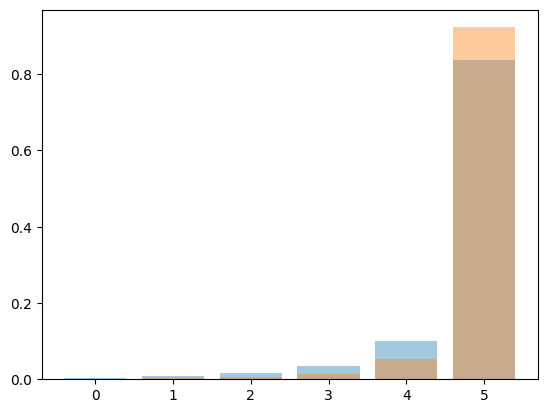

In [15]:
plt.bar(list(range(6)), t_x[t_y.argmin(dim=1).to(bool)].mean(dim=0), alpha=0.4)
plt.bar(list(range(6)), t_x[t_y.argmax(dim=1).to(bool)].mean(dim=0), alpha=0.4)

<BarContainer object of 6 artists>

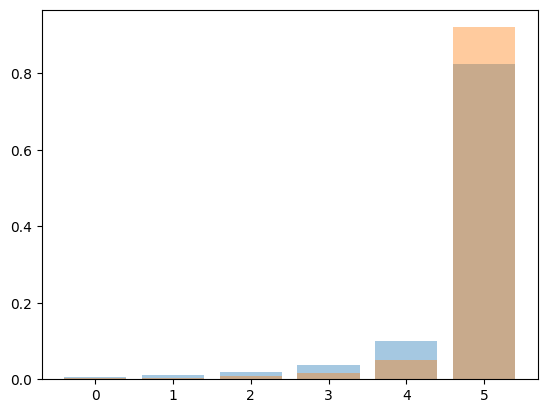

In [16]:
plt.bar(list(range(6)), attack_x[attack_y.argmin(dim=1).to(bool)].mean(dim=0), alpha=0.4)
plt.bar(list(range(6)), attack_x[attack_y.argmax(dim=1).to(bool)].mean(dim=0), alpha=0.4)

In [26]:
query_zero_hop(t_model, s_data.x[0])

tensor([[-1.6288, -1.5556,  0.2882,  5.3236, -1.2754,  0.3285]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
query_zero_hop(s_model, s_data.x[0])

tensor([[-2.0381, -2.7032, -1.2279,  4.5965, -1.2803, -1.0144]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
query_zero_hop(t_model, s_data.x[0])

tensor([[-1.6288, -1.5556,  0.2882,  5.3236, -1.2754,  0.3285]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [32]:
s_data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327, 6], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [46]:
for x in s_data.x:
    t_pred = query_zero_hop(t_model, x).softmax(dim=1)[0].log()
    s_pred = query_zero_hop(s_model, x).softmax(dim=1)[0].log()
#     print(s_pred.softmax(dim=1)[0])
#     print(s_pred)
    print(F.kl_div(t_pred, s_pred, log_target=True))

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2051, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7845e-05, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0251, device='cuda

In [19]:
att_model(t_x.to(DEVICE)).detach().cpu()

tensor([[-0.2024,  0.2694],
        [-0.2251,  0.2920],
        [ 1.3049, -1.1046],
        ...,
        [-0.2102,  0.2770],
        [-0.1613,  0.2264],
        [ 0.3046, -0.1908]])

In [20]:
count = 0
for i in range(t_data.num_nodes):
    
    if t_data.train_mask[i]:
        pred = query_zero_hop(t_model, t_data.x[i]).detach().cpu()
        print(pred, 1)
    elif t_data.test_mask[i]:
        pred = query_zero_hop(t_model, t_data.x[i]).detach().cpu()
        print(pred, 0)
count

tensor([[-0.3306,  6.5233,  0.3790, -5.2127, -0.0700, -1.2676]]) 0
tensor([[-4.2230, -2.8926, -2.3202, -0.6136, -1.0923,  9.0295]]) 1
tensor([[-2.4567,  1.2455, -0.1968, -0.6522, -0.1249,  1.4294]]) 0
tensor([[-0.1942,  6.4990,  1.1117, -1.6230, -1.8155, -2.8304]]) 1
tensor([[-0.1924,  1.3156,  5.0560, -0.7706, -1.6254, -0.9846]]) 0
tensor([[ 0.0217, -4.1570, -5.0231,  3.4691,  3.9772, -0.7018]]) 0
tensor([[ 3.1671,  2.4182,  5.5301, -2.0429, -3.6690, -4.2726]]) 0
tensor([[-0.0350,  8.1872,  1.3754, -1.5269, -2.2231, -3.7270]]) 0
tensor([[-1.5291,  1.2116,  4.3174,  1.7053, -1.9073,  0.0722]]) 0
tensor([[-1.4291, -0.4917,  7.3205,  2.4674, -1.2470, -2.4339]]) 1
tensor([[-2.8103,  1.2664, -0.1583,  0.6598,  2.2892, -0.2350]]) 1
tensor([[ 3.9910,  2.6695, -1.2225, -0.9036, -1.0643, -5.1664]]) 1
tensor([[-2.5793, -2.8477, -2.4662, -0.0145, -0.1930,  7.0797]]) 0
tensor([[-0.2909,  1.8908,  3.4079,  2.4875, -1.9633, -2.7896]]) 0
tensor([[-1.2980, -0.4327, -1.5348, -0.6909,  0.2168,  2.6888]

0

In [21]:
t_data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327, 6], train_mask=[3327], val_mask=[3327], test_mask=[3327])